In [1]:
import pandas as pd
import numpy as np
import os

# Load index files
base_path = './Dataset/'  # Replace with the path to the dataset directory if needed
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# Function to load a trial's EEG data
def load_trial_data(row, base_path='.'):
    # Determine dataset type based on ID range
    id_num = row['id']
    if id_num <= 4800:
        dataset = 'train'
    elif id_num <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'
    
    # Construct the path to EEGdata.csv
    eeg_path = f"{base_path}/{row['task']}/{dataset}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load the entire EEG file
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate indices for the specific trial
    trial_num = int(row['trial'])
    if row['task'] == 'MI':
        samples_per_trial = 2250  # 9 seconds * 250 Hz
    else:  # SSVEP
        samples_per_trial = 1750  # 7 seconds * 250 Hz
    
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial - 1
    
    # Extract the trial data
    trial_data = eeg_data.iloc[start_idx:end_idx+1]
    return trial_data

# Example: Load data for the first training example
first_trial = validation_df.iloc[0]  # Using index 0 for the first row
trial_data = load_trial_data(first_trial, base_path=base_path)  # Pass the base_path parameter
print(f"Loaded task: {first_trial['task']}, Trial: {first_trial['trial']} for subject {first_trial['subject_id']}")
# Print label if available (only for training and validation data)
if 'label' in first_trial:
    print(f"Label: {first_trial['label']}")
print(f"Data shape: {trial_data.shape}")
print(f"First 5 rows of trial data:\n{trial_data.head()}")

Loaded task: MI, Trial: 1 for subject S31
Label: Left
Data shape: (2250, 18)
First 5 rows of trial data:
           Time            FZ            C3            CZ            C4  \
0  1.000500e+06  311426.59375  321080.50000  359498.84375  368457.43750   
1  1.000500e+06  309546.00000  311528.53125  352108.31250  366678.78125   
2  1.000500e+06  310267.96875  312397.37500  355520.78125  368320.65625   
3  1.000500e+06  312545.87500  322326.75000  364975.56250  371095.56250   
4  1.000500e+06  313246.21875  327401.46875  367259.75000  371133.31250   

             PZ           PO7            OZ           PO8      AccX      AccY  \
0  317776.90625  298857.40625  288538.78125  313009.37500  0.000244  0.820801   
1  309605.56250  296327.18750  287078.75000  310669.50000  0.002197  0.819092   
2  311393.15625  298072.96875  288286.65625  311938.46875  0.005127  0.819580   
3  320610.21875  301668.00000  290481.21875  315051.06250  0.009277  0.818359   
4  324231.18750  302074.53125  290579.9

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class EEGDataset(Dataset):
    def __init__(self, dataframe, base_path='.', task=None):
        if task is not None:
            self.dataframe = dataframe[dataframe['task'] == task].reset_index(drop=True)
        else:
            self.dataframe = dataframe
        self.base_path = base_path

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        trial_data = load_trial_data(row, base_path=self.base_path)
        label = row.get('label', None)  
        return trial_data, label

class EEGDataLoader(DataLoader):
    def __init__(self, dataframe, batch_size=32, shuffle=True, num_workers=0, base_path='.', task=None):
        dataset = EEGDataset(dataframe, base_path=base_path, task=task)
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [3]:
import torch
torch.manual_seed(42) 

In [4]:
train_loader = EEGDataLoader(train_df, batch_size=32, base_path=base_path,task='MI')
validation_loader = EEGDataLoader(validation_df, batch_size=32, base_path=base_path, task='MI')
test_loader = EEGDataLoader(test_df, batch_size=32, base_path=base_path, task='MI')

In [5]:
left_count = train_df['label'].value_counts().get('Left', 0)
right_count = train_df['label'].value_counts().get('Right', 0)
print(f"Left: {left_count}, Right: {right_count}")

Left: 1772, Right: 1812


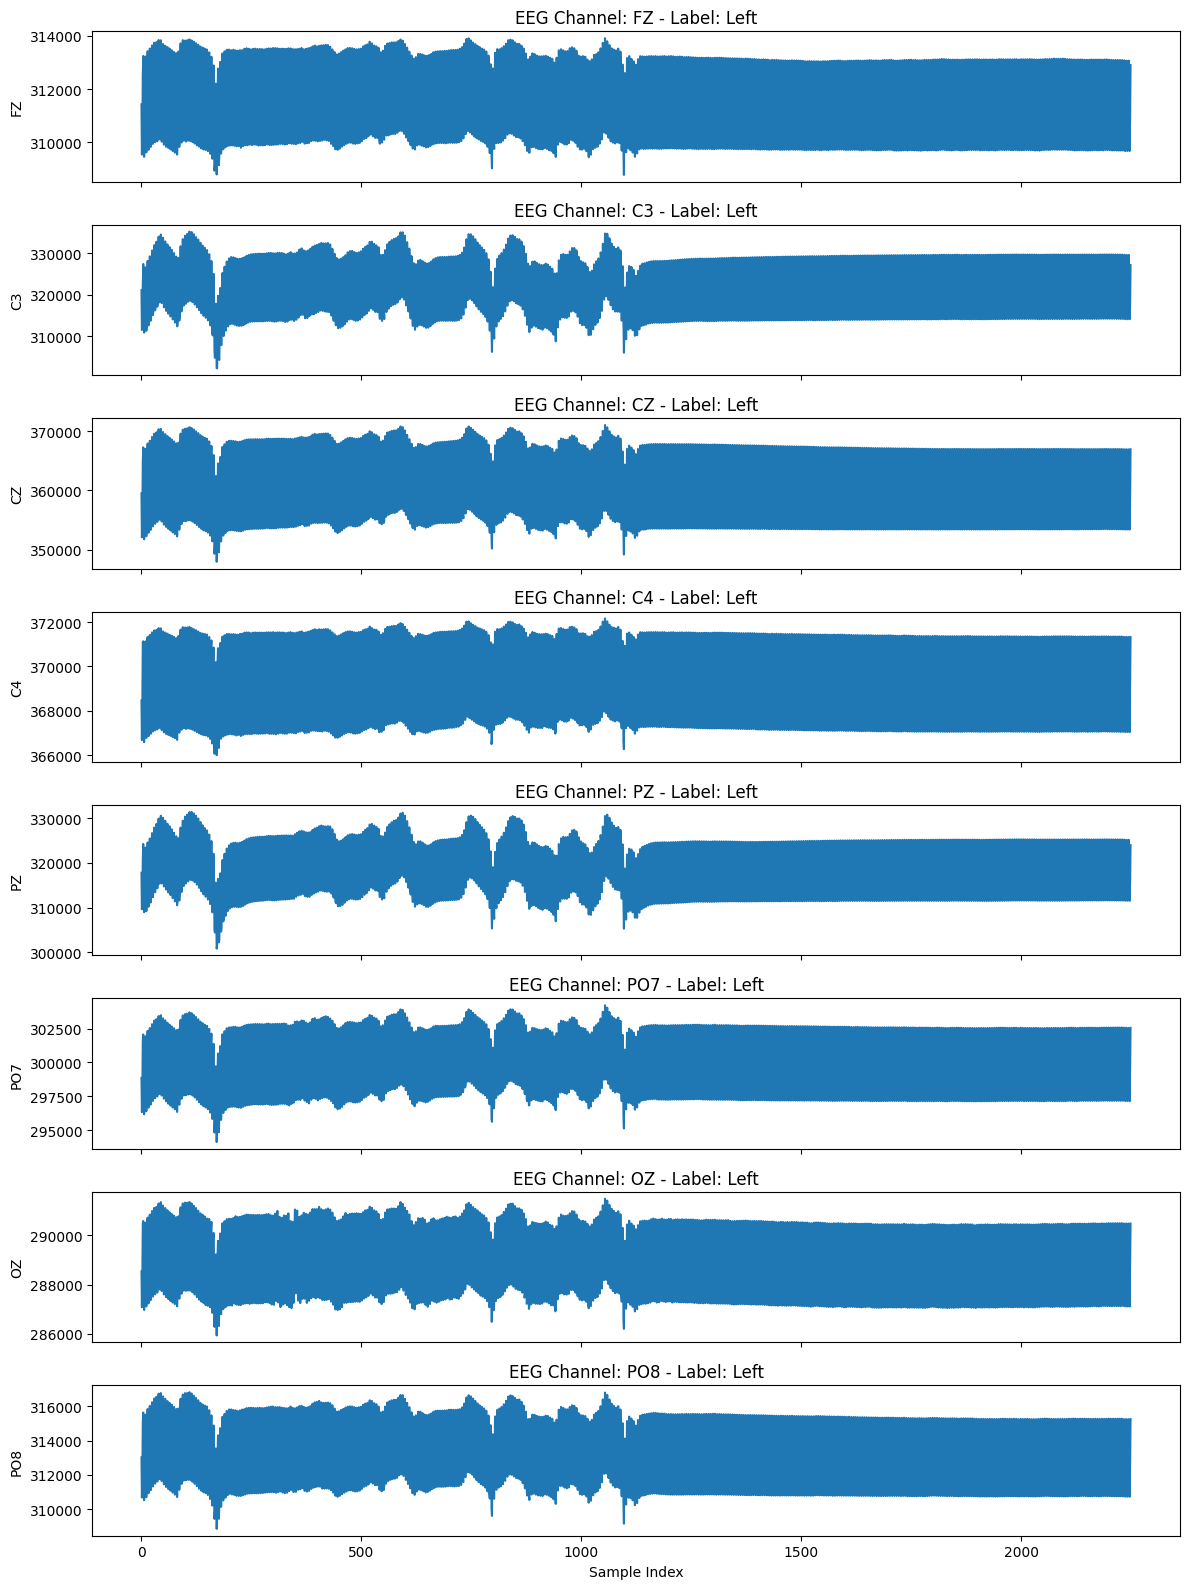

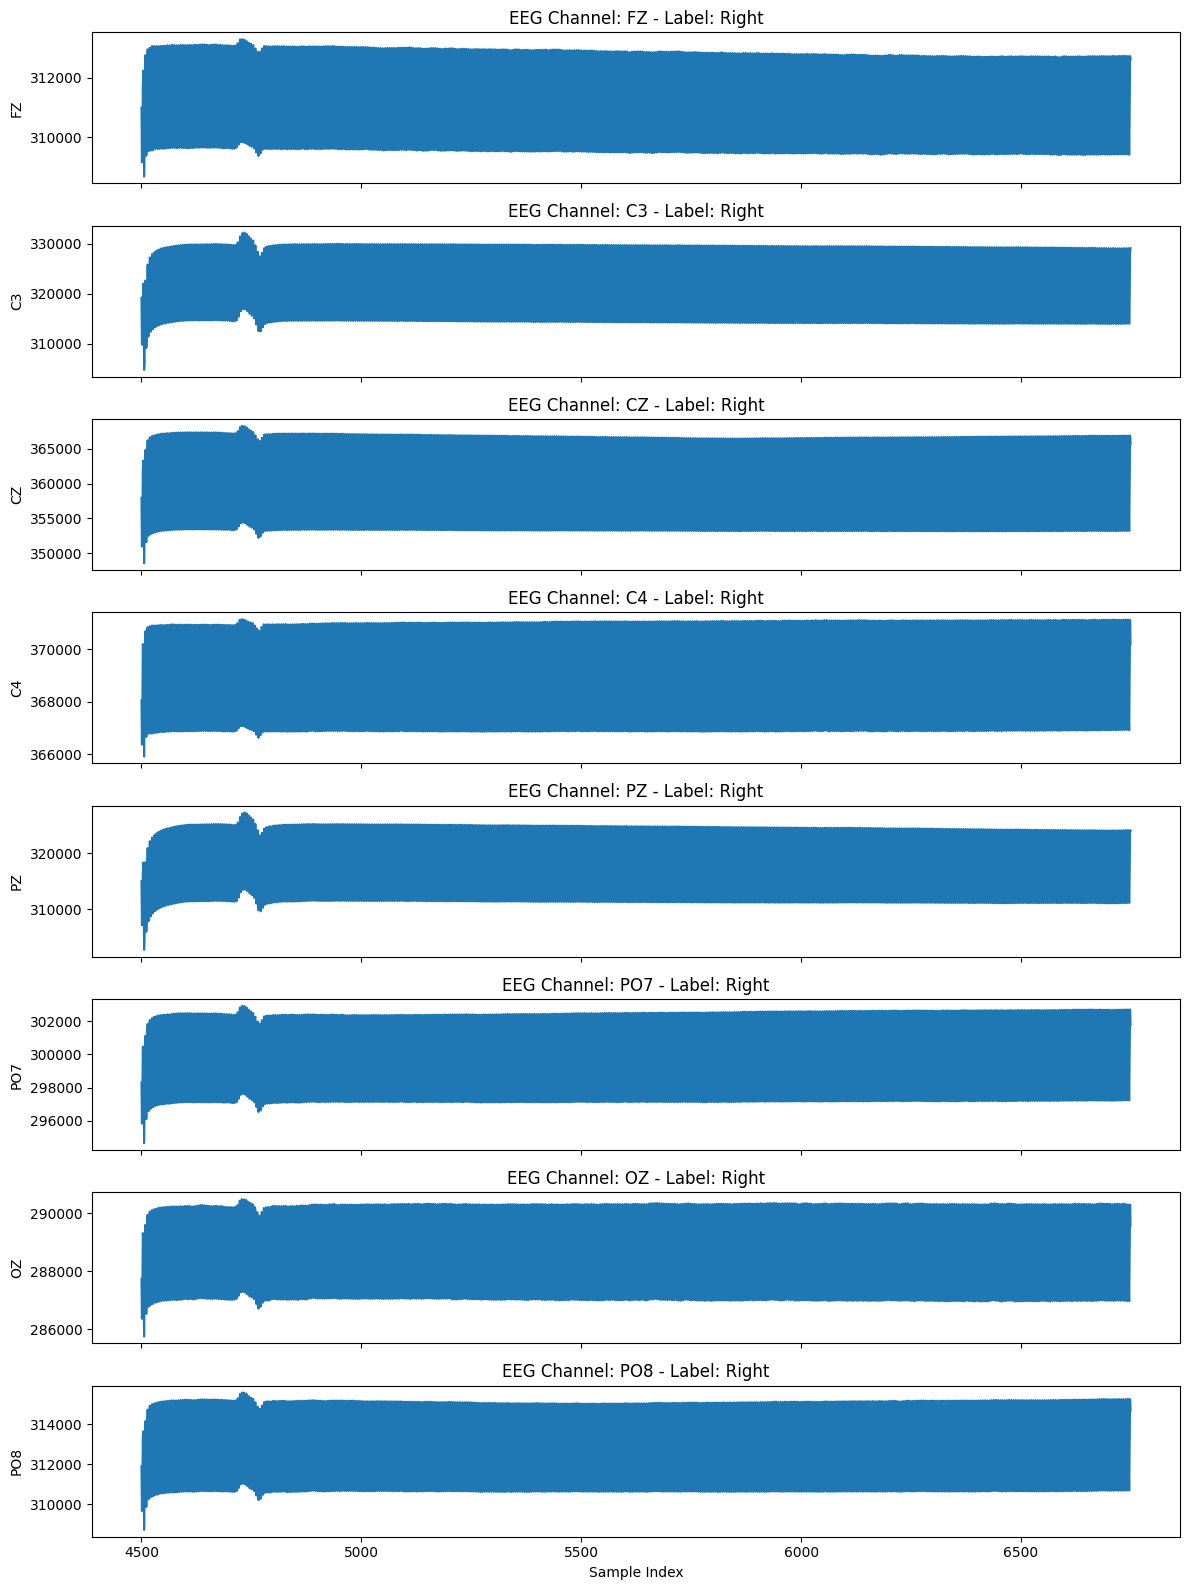

In [11]:
import matplotlib.pyplot as plt

labels = validation_df[(validation_df['task'] == 'MI')]['label'].unique()
for label in labels:
    trial = validation_df[(validation_df['task'] == 'MI') & (validation_df['label'] == label)].iloc[0]
    trial_data = load_trial_data(trial, base_path=base_path)
    fig, axs = plt.subplots(len(eeg_channels), 1, figsize=(12, 2 * len(eeg_channels)), sharex=True)
    for i, ch in enumerate(eeg_channels):
        axs[i].plot(trial_data[ch])
        axs[i].set_ylabel(ch)
        axs[i].set_title(f"EEG Channel: {ch} - Label: {label}")
    axs[-1].set_xlabel("Sample Index")
    plt.tight_layout()
    plt.show()